# Calculating means on directional data in MagIC format using PmagPy

## Introduction

This notebook is a template for importing data and calculating mean directions using PmagPy. You can use it on any MagIC contribution with site level data (or alternatively it could be applied to specimen level data). The example that is given is on paleomagnetic directional data from the following study that is in the MagIC database (https://earthref.org/MagIC/19938):

> MacFadden, Woodburne, and Opdyke (1990). Paleomagnetism and Neogene clockwise rotation of the Northern Cady Mountains, Mojave Desert of southern California. Journal of Geophysical Research: Solid Earth 95 (B4):4597-4608. doi:10.1029/JB095IB04P04597.

### Change the MagIC contribution

You can change what study this notebook is applied to by changing the `magic_id` in the **Download data and unpack data** code cell below.

### Apply to your own `sites.txt` data

You can also substitute in your own MagIC format `sites.txt` file. To do this, skip the **Download data and unpack data** section and go to the **Import the sites table** section after running the **Import packages** code.

## Import packages

In [1]:
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Download and unpack data

### Download MagIC contribution

We can first download the data from MagIC by providing the `magic_id`.
If the directory name that is given is not provided, it will be created.
In the example, the data are put into a folder within this directory that is named `reversal_test_data`.

In [2]:
magic_id='19938'
directory = './mean_determination_data'
result, magic_file_path = ipmag.download_magic_from_id(magic_id, directory=directory)

### Unpack the MagIC file

MagIC contributions are made up of distinct tables that can be unpacked. In this case, we are going to do a reversal test on the site level data so we are particularly interested in unpacking the `sites.txt` table from the MagIC file.

In [3]:
ipmag.unpack_magic(magic_file_path, dir_path=directory, print_progress=False)

1  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/mean_determination_data/contribution.txt
1  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/mean_determination_data/locations.txt
48  records written to file  /Users/unimos/0000_Github/PmagPy-docs/example_notebooks/template_notebooks/mean_determination_data/sites.txt


True

### Import the sites table

We can now use pandas to import the sites table to a pandas dataframe using the function `pd.read_csv()`.

We need to point `pd.read_csv()` to the file which with the above steps has the location and name of `'reversal_test/sites.txt'`. This can be changed if the file is in a different place or has a different name. For example, if it is in the same directory as the notebook it can be: `'sites.txt'`

In [4]:
# change the sites_file path if you want to use a file in a different directory
sites_file = directory + '/sites.txt'
sites = pd.read_csv(sites_file,sep='\t',header=1)
sites.head()

,age_high,age_low,age_unit,citations,dir_dec,dir_inc,dir_tilt_correction,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,site
0,23,17,Ma,10.1029/JB095iB04p04597,198.1,-39.7,100,Sedimentary,Sediment Layer,0.0,34.75,Silt,Hector Formation,244,LP-DIR-T:LP-DIR-AF:DE-BFL,340.0
1,23,17,Ma,10.1029/JB095iB04p04597,62.1,42.5,100,Sedimentary,Sediment Layer,21.0,34.75,Silt,Hector Formation,244,LP-DIR-T:LP-DIR-AF:DE-BFL,342.0
2,23,17,Ma,10.1029/JB095iB04p04597,32.8,48.6,100,Sedimentary,Sediment Layer,27.0,34.75,Silt,Hector Formation,244,LP-DIR-T:LP-DIR-AF:DE-BFL,344.0
3,23,17,Ma,10.1029/JB095iB04p04597,22.8,32.9,100,Sedimentary,Sediment Layer,30.0,34.75,Silt,Hector Formation,244,LP-DIR-T:LP-DIR-AF:DE-BFL,351.0
4,23,17,Ma,10.1029/JB095iB04p04597,55.0,23.6,100,Sedimentary,Sediment Layer,39.0,34.75,Silt,Hector Formation,244,LP-DIR-T:LP-DIR-AF:DE-BFL,349.0


### Filter by tilt correction

When there are data in both geographic coordinates (without correction for bedding tilt) and data in tilt corrected coordinates, they each get their own row with different values in the `dir_tilt_correction` column:

- 0: No tilt correction applied. The data are in the geographic coordinate system (i.e., as they are currently oriented in the field).
- 100: Full (100%) tilt correction applied. The data are in the paleohorizontal coordinate system, meaning they have been corrected for tilting to represent their original horizontal position. 

In the example dataset, only the tilt-corrected values are available. As a result, all the entries have a `dir_tilt_correction` of 100. 
For completeness, we will filter and make a `sites_geo` dataframe where `dir_tilt_correction` is 0 and 
a `sites_tc` dataframe where `dir_tilt_correction` is 100. For this example, `sites_geo` will be empty, but 
it will be populated for a MagIC contribution where there are data in those coordinates.

In [5]:
sites_geo = sites[sites['dir_tilt_correction'] == 0]
sites_tc = sites[sites['dir_tilt_correction'] == 100]

### Make declination/inclination lists

We can extract specific columns from the dataframe by using the nomenclature `dataframe_name['column_name']`. In this case, we want to conduct a reversal test on the data in the `sites_geo` dataframe and are interested in the directional data which are the declination column `dir_dec` and the inclination column `dir_inc`. So using the code `sites['dir_dec']` will give us all the declinations which we can assign to a variable `sites_dec`.

If you wanted to do the test on the `sites_tc` data, you would switch in `sites_tc` for `sites_geo` in the text below.

In [6]:
sites_dec = sites_tc['dir_dec']
sites_inc = sites_tc['dir_inc']

## Plot the directions

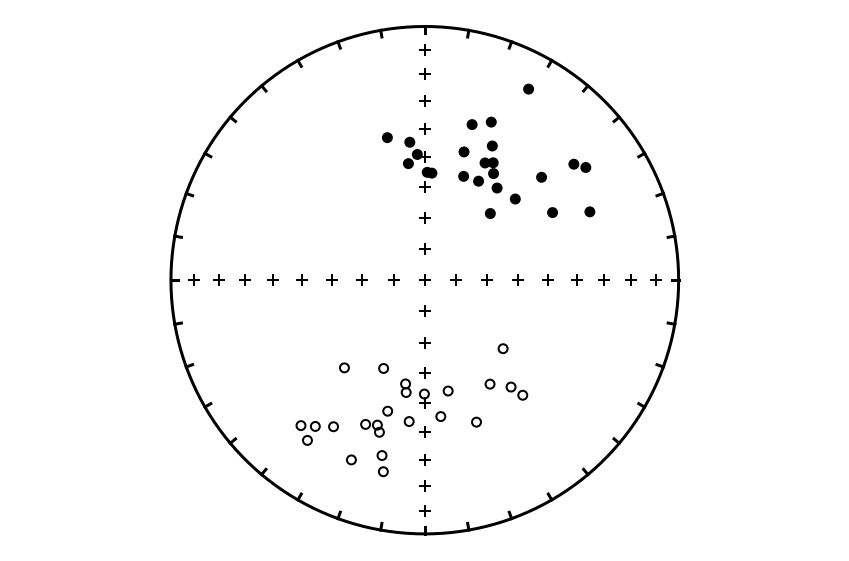

In [7]:
ipmag.plot_net()
ipmag.plot_di(sites_dec,sites_inc)

## Separate the data by polarity

Let's focus on calculating the mean for the normal polarity data. To do that, we need to separate the data into the two polarity modes. This can be done with the `ipmag.separate_directions()` function. **Skip this step if you have single polarity data**:

In [8]:
dec_normal, inc_normal, dec_reversed, inc_reversed = ipmag.separate_directions(sites_dec,sites_inc)
sites_dec = dec_normal
sites_inc = inc_normal

## Calculate Fisher mean

Now that we have extracted the declination and inclination values, let's calculate the Fisher mean.

In [9]:
site_mean = ipmag.fisher_mean(sites_dec,sites_inc)
site_mean

{'dec': 28.036900368913685,
 'inc': 45.655647454684676,
 'n': 24,
 'r': 22.63536254133362,
 'k': 16.854293317198863,
 'alpha95': 7.425731242923154,
 'csd': 19.73012083339684}

`ipmag.fisher_mean` returns a dictionary with keys corresponding to the different parameters of the Fisher mean. We can print out a pretty version of the mean using `ipmag.print_direction_mean(site_mean)`.

In [10]:
ipmag.print_direction_mean(site_mean)

Dec: 28.0  Inc: 45.7
Number of directions in mean (n): 24
Angular radius of 95% confidence (a_95): 7.4
Precision parameter (k) estimate: 16.9


## Plot the directions and Fisher mean

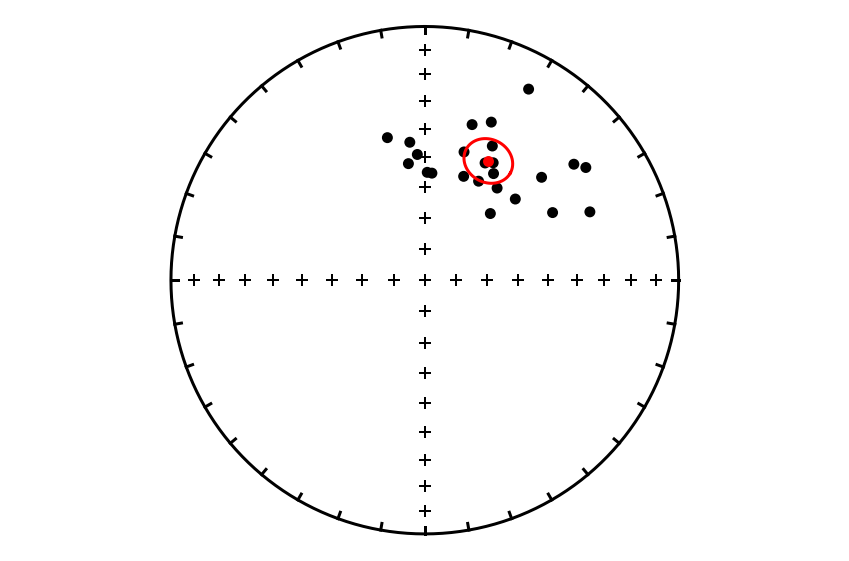

In [11]:
ipmag.plot_net()
ipmag.plot_di(sites_dec,sites_inc)
ipmag.plot_di_mean(site_mean['dec'],site_mean['inc'],site_mean['alpha95'],color='red')

## Calculate bootstrap confidence region

As shown in Tauxe et al. (1991), these example data are not consistent with a Fisher distribution—as is the case for many datasets. In such cases, a non-parametric approach can be taken to estimate the confidence region for the mean of directions. We can use the function `ipmag.mean_confidence_bootstrap` to determine the confidence region of the mean without assuming a Fisher distribution using the method of:

> Heslop, D., Scealy, J. L., Wood, A. T. A., Tauxe, L., & Roberts, A. P. (2023). A bootstrap common mean direction test. Journal of Geophysical Research: Solid Earth, 128, e2023JB026983. https://doi.org/10.1029/2023JB026983

In [12]:
bootstrap_mean, bootstrap_confidence = ipmag.mean_bootstrap_confidence(sites_dec,sites_inc,num_sims=10000)

This function returns:
1) a dictionary of parameters the includes the estimated mean 
direction and the T statistic which is the basis of the bootstrap confidence region
2) list of [dec, inc] pairs that represent the boundary of the confidence region. The bootstrap confidence region cannot be reported readily in a compact form so is instead a long list of points along the boundary of the confidence region.

Let's look at the mean.

In [13]:
bootstrap_mean

{'dec': 28.036900368913685,
 'inc': 45.655647454684676,
 'T_critical': 8.237331235732217}

## Plot the bootstrap confidence region

We can plot the bootstrap confidence region for the mean using the `ipmag.plot_bootstrap_confidence()` function which takes the mean and the confidence region output from `ipmag.mean_bootstrap_confidence()` function. 

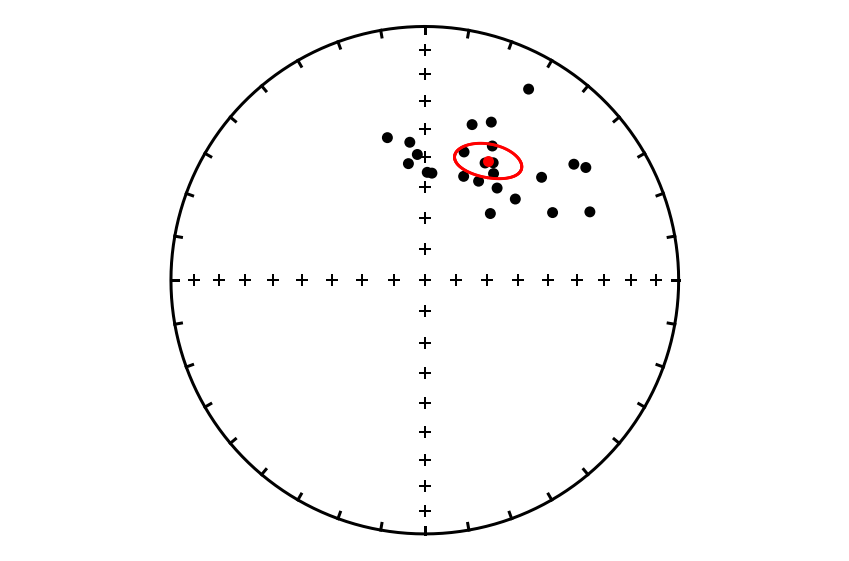

In [14]:
ipmag.plot_net()
ipmag.plot_di(sites_dec,sites_inc)
ipmag.plot_bootstrap_confidence(bootstrap_mean['dec'], bootstrap_mean['inc'], bootstrap_confidence,
                                mean_color='red', confidence_color='red',)